**<center>BỘ GIÁO DỤC VÀ ĐÀO TẠO</center>**
**<center>TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP.HỒ CHÍ MINH</center>**
**<center>KHOA CÔNG NGHỆ THÔNG TIN</center>**
**<center>BÁO CÁO ĐỒ ÁN</center>**
**<center>MÔN HỌC : KHOÁ LUẬN TỐT NGHIỆP</center>**
**<center>TÊN ĐỀ TÀI: DIFFERENTIAL PRIVACY IN DEEP LEARNING</center>**
**<center>GVHD: PGS.TS Hoàng Văn Dũng</center>**
**<center>GVPB: ThS Lê Thị Minh Châu</center>**

**Sinh viên thực hiện**<br>
- Huỳnh Nguyễn Như Nguyên - 20133019<br>
- Lê Minh Trí - 20133100<br>

### Giới thiệu về notebook
Notebook này mô tả về quá trình xây dựng một mô hình mạng CNN giúp phân biệt ảnh mặt thật và giả.


#### 1. Tải và tiền xử lý dữ liệu

In [15]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset,  random_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, fake_dir, real_dir, transform=None):
        self.fake_dir = fake_dir
        self.real_dir = real_dir
        self.transform = transform

        self.fake_images = [(os.path.join(fake_dir, img), 1) for img in os.listdir(fake_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.real_images = [(os.path.join(real_dir, img), 0) for img in os.listdir(real_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

        self.all_images = self.fake_images + self.real_images

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
fake_dir = './data/fake'
real_dir = './data/real'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
])
dataset = CustomDataset(fake_dir, real_dir, transform=transform)


#### 2. Chia tập dữ liệu

In [17]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 2331
Validation size: 499
Test size: 500


In [18]:
'''# Đếm số lượng nhãn 0 và 1
num_fake = sum(1 for _, label in dataset if label == 1)
num_real = sum(1 for _, label in dataset if label == 0)

print(f"Số lượng ảnh fake (nhãn 1): {num_fake}")
print(f"Số lượng ảnh real (nhãn 0): {num_real}")'''

'# Đếm số lượng nhãn 0 và 1\nnum_fake = sum(1 for _, label in dataset if label == 1)\nnum_real = sum(1 for _, label in dataset if label == 0)\n\nprint(f"Số lượng ảnh fake (nhãn 1): {num_fake}")\nprint(f"Số lượng ảnh real (nhãn 0): {num_real}")'

#### 3. Định nghĩa cấu trúc mô hình

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  
        self.fc2 = nn.Linear(512, 2)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNNModel()

#### 4. Huấn luyện mô hình

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
num_epochs = 20
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Accuracy: {100 * correct / total:.2f}%")

Epoch [1/20], Training Loss: 0.6933, Training Acc: 50.36%
Validation Loss: 0.6933, Validation Acc: 46.49%
Epoch [2/20], Training Loss: 0.6902, Training Acc: 53.71%
Validation Loss: 0.6657, Validation Acc: 58.12%
Epoch [3/20], Training Loss: 0.6389, Training Acc: 64.78%
Validation Loss: 0.6468, Validation Acc: 64.13%
Epoch [4/20], Training Loss: 0.5998, Training Acc: 67.65%
Validation Loss: 0.5965, Validation Acc: 67.94%
Epoch [5/20], Training Loss: 0.5758, Training Acc: 68.43%
Validation Loss: 0.5711, Validation Acc: 70.94%
Epoch [6/20], Training Loss: 0.5622, Training Acc: 70.48%
Validation Loss: 0.5629, Validation Acc: 70.94%
Epoch [7/20], Training Loss: 0.5437, Training Acc: 71.43%
Validation Loss: 0.5364, Validation Acc: 74.15%
Epoch [8/20], Training Loss: 0.5397, Training Acc: 71.26%
Validation Loss: 0.5318, Validation Acc: 72.95%
Epoch [9/20], Training Loss: 0.5254, Training Acc: 72.07%
Validation Loss: 0.5317, Validation Acc: 70.94%
Epoch [10/20], Training Loss: 0.5179, Training

#### 5. Lưu mô hình và số liệu

In [22]:
torch.save(model,'./model/FakeAndReal.pth')
torch.save(model.state_dict(),'./model/FakeAndRealState.pth')


In [23]:
import pickle
history_save_path = './model/history.pkl'
with open(history_save_path, 'wb') as f:
    pickle.dump(history, f)

#### 6. Đánh giá, kiểm tra mô hình

In [24]:
with open(history_save_path, 'rb') as f:
    history = pickle.load(f)

In [25]:
import matplotlib.pyplot as plt
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

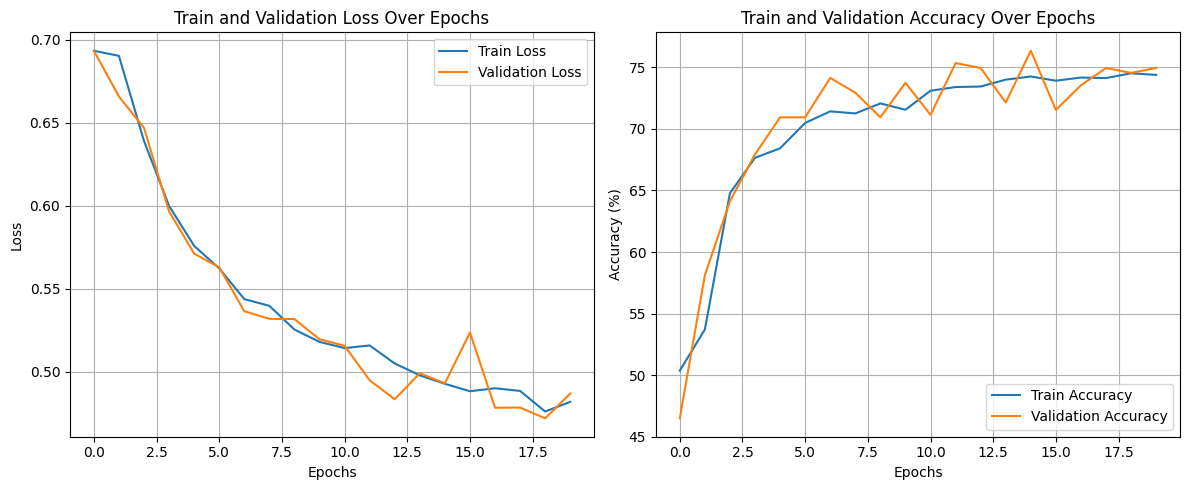

In [26]:
plot_metrics(history)

In [27]:
model = torch.load('./model/FakeAndReal.pth')

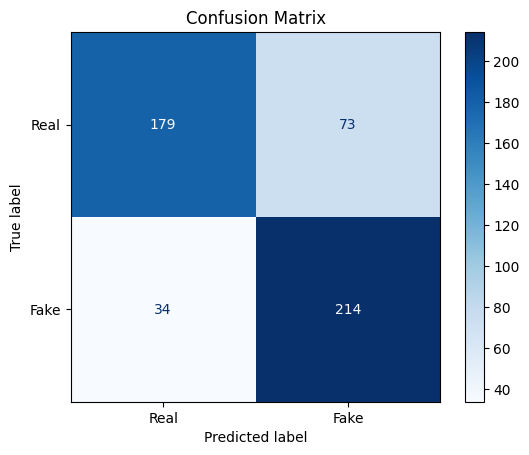

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader):
    all_labels = []
    all_preds = []
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig('matrix.png')
    plt.show()

plot_confusion_matrix(model, test_loader)

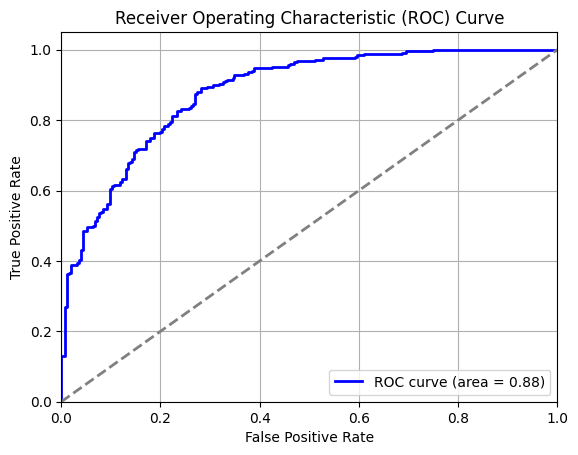

In [30]:
from sklearn.metrics import roc_curve, auc
def plot_roc_auc(model, test_loader):
    all_labels = []
    all_probs = []
    model.eval()
    

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.numpy())
            all_probs.extend(probabilities.numpy())
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('Curve.png')
    plt.show()
plot_roc_auc(model, test_loader)